# Time Series Analysis: Day Trading with Machine Learning

In [1]:
# Numerical Computing
import numpy as np
# Data Management
import pandas as pd
# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.pipeline import Pipeline  # A
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

### Loading Data

In [2]:
price_df = pd.read_csv('/work/twlo_prices.csv')
price_df.head()

,close,volume,date
0,99.98,93417.0,2020-01-02 14:30:00+00:00
1,99.78,16685.0,2020-01-02 14:31:00+00:00
2,100.14,21998.0,2020-01-02 14:32:00+00:00
3,100.35,18348.0,2020-01-02 14:33:00+00:00
4,100.55,22181.0,2020-01-02 14:34:00+00:00


### Setting a Time Index in Pandas

In [3]:
# Setting index on Date Column
price_df.index = pd.to_datetime(price_df['date'])  
price_df.index = price_df.index.tz_convert('US/Pacific')  

#Sort Out by Index(time)
price_df.sort_index(inplace=True)  

# Deleting Date Column
del price_df['date']  

In [4]:
price_df.head()

,close,volume
date,,
2020-01-02 06:30:00-08:00,99.98,93417.0
2020-01-02 06:31:00-08:00,99.78,16685.0
2020-01-02 06:32:00-08:00,100.14,21998.0
2020-01-02 06:33:00-08:00,100.35,18348.0
2020-01-02 06:34:00-08:00,100.55,22181.0


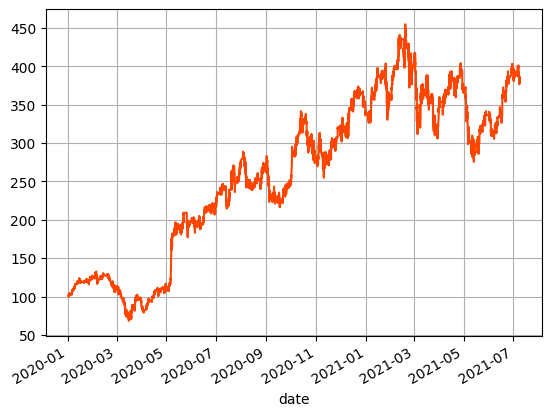

In [5]:
price_df['close'].plot(color='orangered')
plt.grid(True)
plt.show()

In [6]:
# Calculating the ending price
last_price_of_the_day = price_df.groupby(price_df.index.date).tail(1)['close'].rename('day_close_price')  
last_price_of_the_day.index = last_price_of_the_day.index.date  

#Adding column to Price DataFrame
price_df['day'] = price_df.index.date  

# Merging end price
price_df = price_df.merge(last_price_of_the_day, left_on='day', right_index=True)  

# Percentage Change
price_df['pct_change_eod'] = (price_df['day_close_price'] - price_df['close']) / price_df['close']   

# Stock price binary response
price_df['stock_price_rose'] = price_df['pct_change_eod'] > 0  

price_df.head()

,close,volume,day,day_close_price,pct_change_eod,stock_price_rose
date,,,,,,
2020-01-02 06:30:00-08:00,99.98,93417.0,2020-01-02,103.15,0.031706,True
2020-01-02 06:31:00-08:00,99.78,16685.0,2020-01-02,103.15,0.033774,True
2020-01-02 06:32:00-08:00,100.14,21998.0,2020-01-02,103.15,0.030058,True
2020-01-02 06:33:00-08:00,100.35,18348.0,2020-01-02,103.15,0.027902,True
2020-01-02 06:34:00-08:00,100.55,22181.0,2020-01-02,103.15,0.025858,True


## Feature Construction

### Date/Time Features

- Creating Date/Time Features

In [7]:
# Datetime features
price_df['feature__dayofweek'] = price_df.index.dayofweek  
price_df['feature__morning'] = price_df.index.hour < 12  

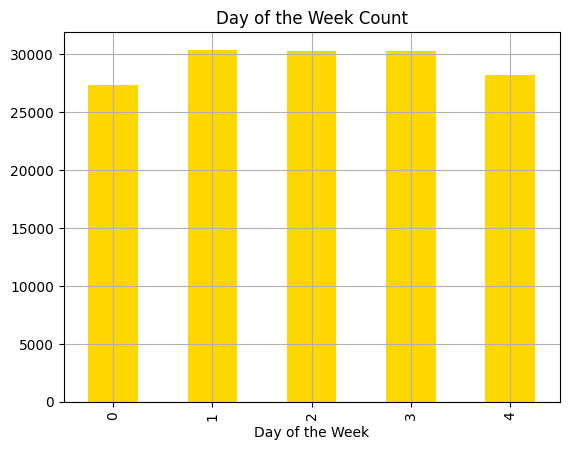

In [8]:
price_df['feature__dayofweek'].value_counts().sort_index().plot(kind='bar', color='gold',title='Day of the Week Count')
plt.xlabel('Day of the Week')
plt.grid(True)
plt.show()

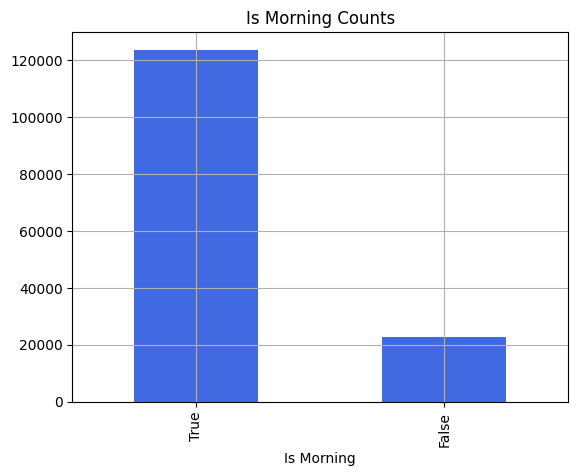

In [9]:
price_df['feature__morning'].value_counts().plot(kind='bar', color='royalblue', title='Is Morning Counts')
plt.xlabel('Is Morning')
plt.grid(True)
plt.show()

### Lag Features

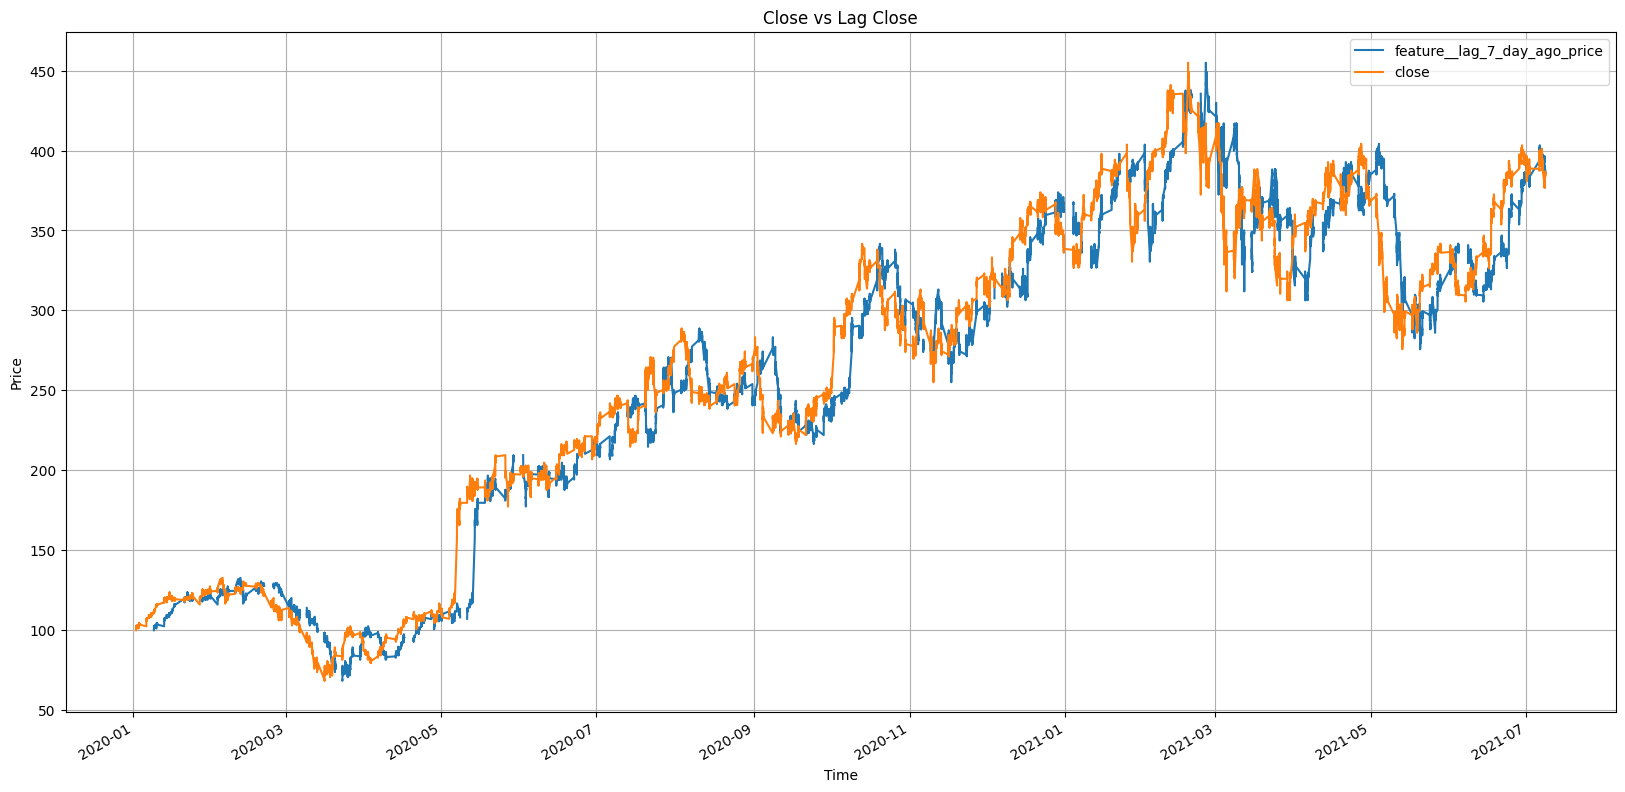

In [10]:
# Price 30 minutes ago
price_df['feature__lag_30_min_ago_price'] = price_df['close'].shift(30, freq='T')

# Price 7 days ago
price_df['feature__lag_7_day_ago_price'] = price_df['close'].shift(7, freq='D')


# Visualizing Features
price_df['feature__lag_7_day_ago_price'].plot(figsize=(20,10), title='Close vs Lag Close')
price_df['close'].plot()
plt.legend()
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.show()

### Rolling/Expandin Window Features

- Rolling-Window Feature

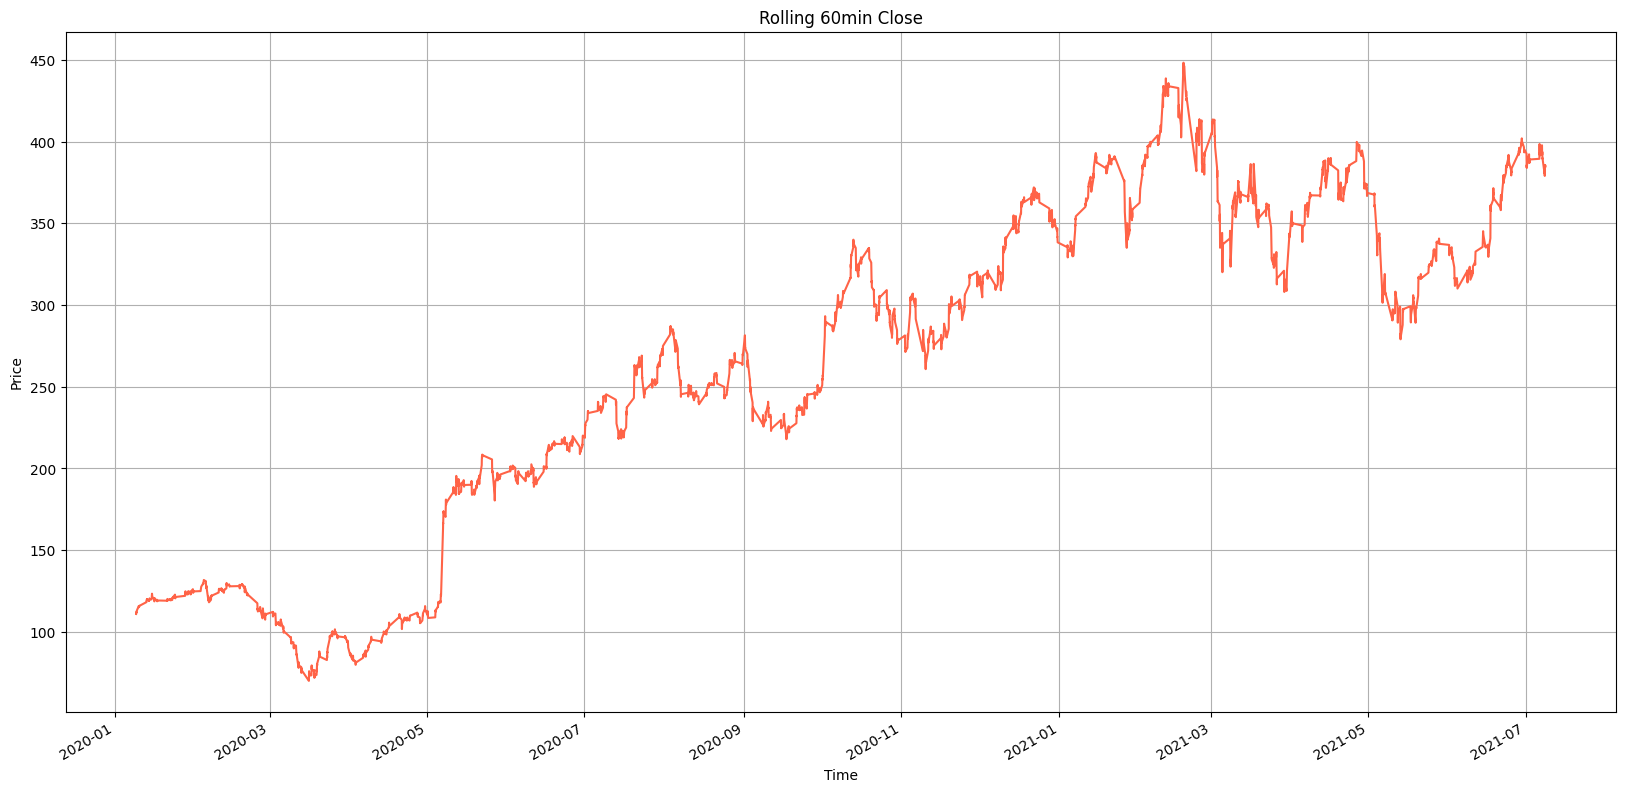

In [11]:
price_df['feature__rolling_close_mean_60'] = price_df['close'].rolling('60min').mean() 
price_df['feature__rolling_close_std_60'] = price_df['close'].rolling('60min').std() 
price_df['feature__rolling_volume_mean_60'] = price_df['volume'].rolling('60min').mean() 
price_df['feature__rolling_volume_std_60'] = price_df['volume'].rolling('60min').std() 

price_df.dropna(inplace=True)

price_df['feature__rolling_close_mean_60'].plot(figsize=(20, 10), color='tomato', title='Rolling 60min Close')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.show()

- Expanding-Window Features

In [12]:
price_df['feature__expanding_close_mean'] = price_df['close'].expanding(200).mean()
price_df['feature__expanding_volume_mean'] = price_df['volume'].expanding(200).mean()

price_df.dropna(inplace=True)

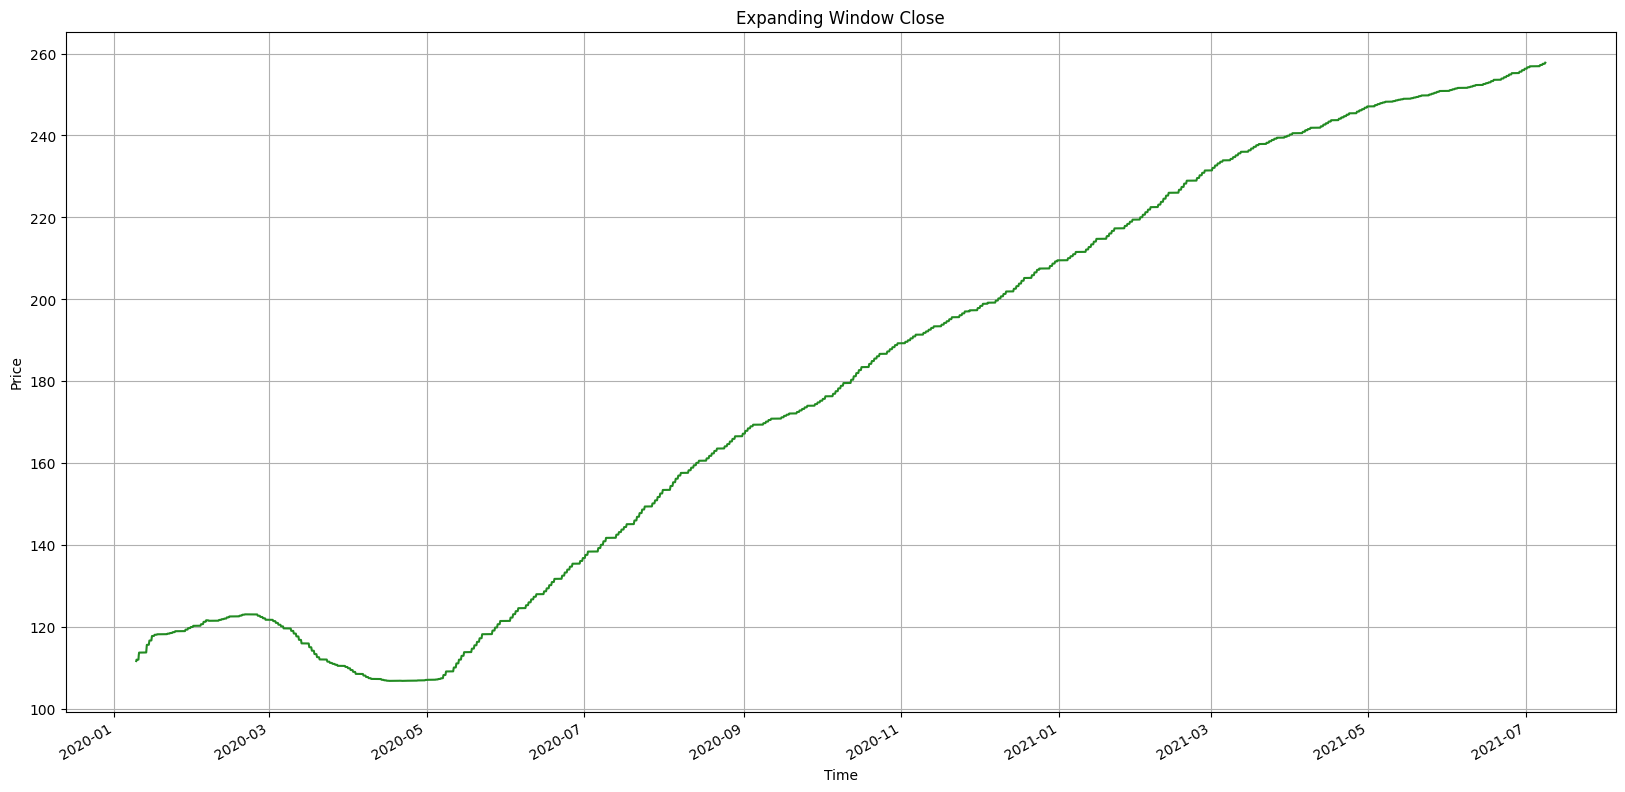

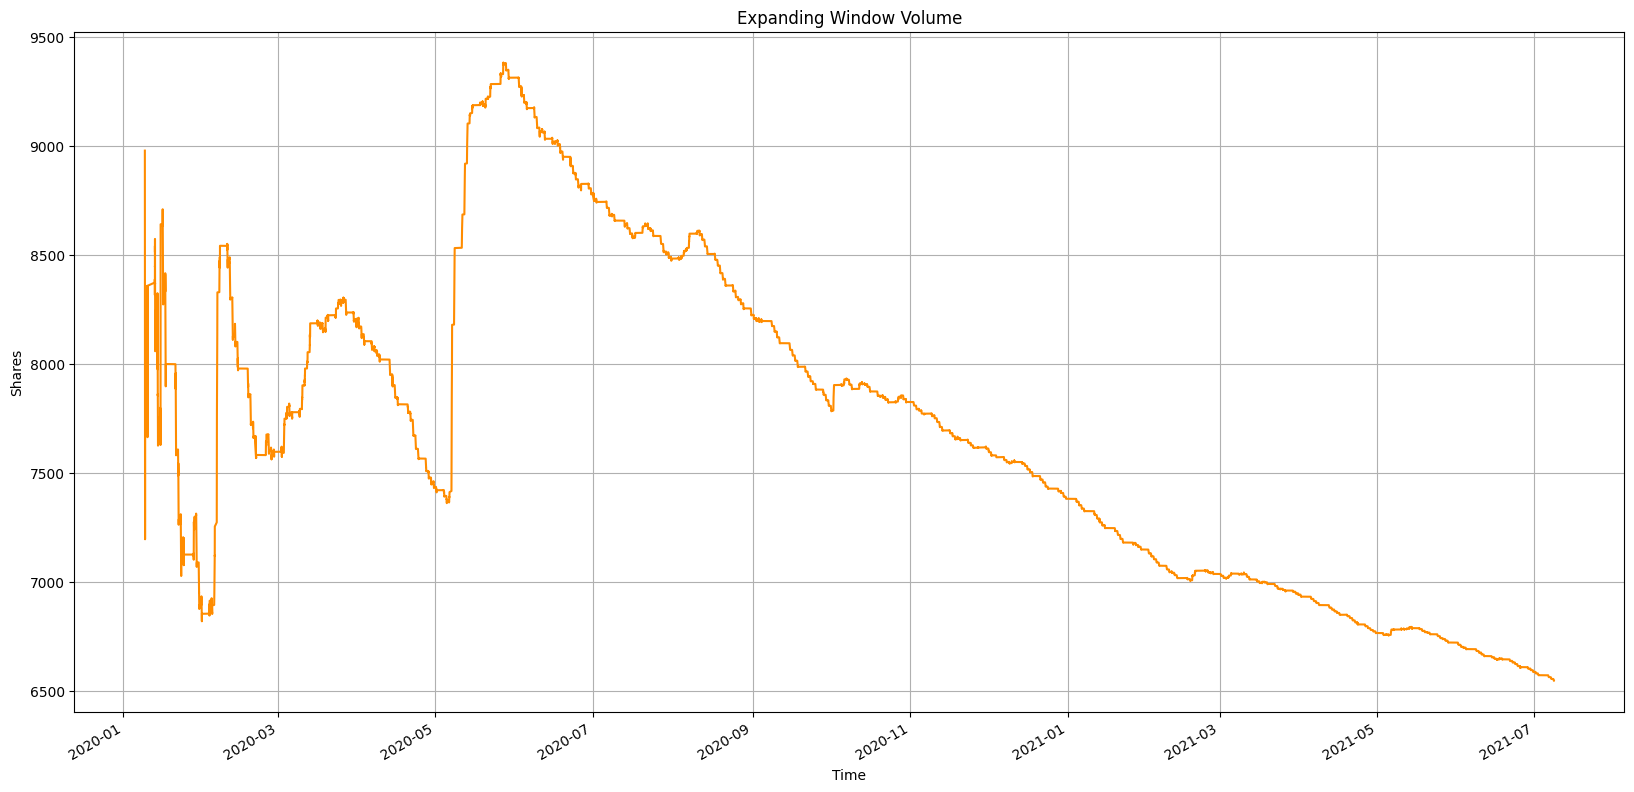

In [13]:
price_df['feature__expanding_close_mean'].plot(figsize=(20, 10), color='forestgreen',title='Expanding Window Close')

plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.show()

price_df['feature__expanding_volume_mean'].plot(figsize=(20, 10), color='darkorange',title='Expanding Window Volume')

plt.xlabel('Time')
plt.ylabel('Shares')
plt.grid(True)
plt.show()

### Creating a Baseline Model

In [14]:
%run /work/Base.ipynb

- Setting Up Pipeline

In [15]:
# Setting Classifier
clf = RandomForestClassifier(random_state=0)

# Building Pipeline
ml_pipeline = Pipeline([  
    ('scale', StandardScaler()),
    ('classifier', clf)
])

params = {  
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__min_samples_split': [2, 3, 5],
    
    'classifier__max_depth': [10, None],
    'classifier__max_features': [None, 'auto']
}

In [16]:
# Splitting Optimization for Time Series
from sklearn.model_selection import TimeSeriesSplit  

tscv = TimeSeriesSplit(n_splits=2)  

- Time Series CV Splits

In [17]:
for i, (train_index, test_index) in enumerate(tscv.split(price_df)):
    train_times, test_times = price_df.iloc[train_index].index, price_df.iloc[test_index].index
    print(f'Iteration {i}\n-------------')
    print(f'''Training between {train_times.min().date()} and {train_times.max().date()}. Testing between {test_times.min().date()} and {test_times.max().date()}\n'''
    )

Iteration 0
-------------
Training between 2020-01-09 and 2020-07-01. Testing between 2020-07-01 and 2020-12-22

Iteration 1
-------------
Training between 2020-01-09 and 2020-12-22. Testing between 2020-12-22 and 2021-07-08



- Building a Helper Function

In [18]:
def split_data(price_df):
    ''' This function takes in our price dataframe and splits it into a training and validation set
    as well as filtering our rows to only use rows that are on the hour
    '''
    downsized_price_df = price_df[(price_df.index.minute == 0)]  
    train_df, test_df = downsized_price_df[:'2021-05-31'], downsized_price_df['2021-06-01':]  
    train_X, test_X = train_df.filter(regex='feature'), test_df.filter(regex='feature')  
    train_y, test_y = train_df['stock_price_rose'], test_df['stock_price_rose'] 
    return train_df, test_df, train_X, train_y, test_X, test_y

### Running First Baseline Model

In [19]:
train_df, test_df, train_X, train_y, test_X, test_y = split_data(price_df)

print("Date-time/Lag/Window/Rolling features + Random Forest\n==========================")
best_model, test_preds, test_probas = advanced_grid_search(
    train_X, train_y,
    test_X, test_y,
    ml_pipeline, params, 
    cv=tscv, include_probas=True  
)

Date-time/Lag/Window/Rolling features + Random Forest
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly 

- Checking Null Accuracy

In [20]:
test_y.value_counts(normalize=True)

False    0.510638
True     0.489362
Name: stock_price_rose, dtype: float64

- Helper Function: Plotting Gains on The First Prediction Each Day

In [21]:
def plot_gains(df, response, predictions):
    ''' A simulation of acting on the First prediction of the day '''
    df['predictions'] =  predictions
    df['movement_correct_multiplier'] = (predictions == response).map({True: 1, False: -1})
    df['gain'] = df['movement_correct_multiplier'] * df['pct_change_eod'].abs()
    
    
    bullish = df[predictions == True]
    bullish_gains = bullish.sort_index().groupby(bullish.index.date).head(1)['gain']
    bullish_gains.cumsum().plot(label='Bullish Only', legend=True)
    print(f'% of time with profit: {(bullish_gains.cumsum() > 0).mean():.3f}')
    print(f'Total Gains for bullish is {bullish_gains.sum():.3f}')
    
    bearish = df[predictions == False]
    bearish_gains = bearish.sort_index().groupby(bearish.index.date).head(1)['gain']
    bearish_gains.cumsum().plot(label='Bearish Only', legend=True)
    print(f'% of time with profit: {(bearish_gains.cumsum() > 0).mean():.3f}')
    print(f'Total Gains for bearish is {bearish_gains.sum():.3f}')
    
    gains = df.sort_index().groupby(df.index.date).head(1)['gain']
    gains.cumsum().plot(label='All Predictions', legend=True)
    print(f'% of time with profit: {(gains.cumsum() > 0).mean():.3f}')
    print(f'Total Gains for all predictions is {gains.sum():.3f}')
    
    plt.title('Gains')
    plt.xlabel('Time')
    plt.ylabel('Cumulative Gains')
    plt.grid(True)
    plt.show()

% of time with profit: 0.077
Total Gains for bullish is -0.043
% of time with profit: 0.500
Total Gains for bearish is -0.004
% of time with profit: 0.308
Total Gains for all predictions is -0.021


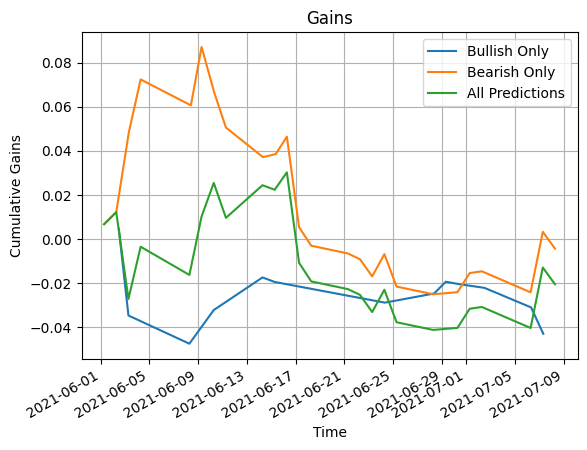

In [22]:
plot_gains(test_df.copy(), test_y, test_preds)

## Domain-Specific Features

- Calculating Daily Price Features

In [23]:
daily_features = pd.DataFrame()  

daily_features['first_5_min_avg_close'] = price_df.groupby(
    price_df.index.date
)['close'].apply(lambda x: x.head().mean())  
daily_features['last_5_min_avg_close'] = price_df.groupby(
    price_df.index.date
)['close'].apply(lambda x: x.tail().mean())  


daily_features['feature__overnight_change_close'] = \
    (daily_features['first_5_min_avg_close'] - daily_features['last_5_min_avg_close'].shift(1)) / daily_features['last_5_min_avg_close'].shift(1)  
daily_features['feature__monthly_pct_change_close'] = daily_features['first_5_min_avg_close'].pct_change(periods=31)  
daily_features['feature__expanding_average_close'] = daily_features['first_5_min_avg_close'].expanding(31).mean()  

### Moving-Average Convergence Divergence

- Calculating MACD

In [24]:
def macd(ticker):  
    exp1 = ticker.ewm(span=12, adjust=False).mean()
    exp2 = ticker.ewm(span=26, adjust=False).mean()
    macd = exp1 - exp2
    return macd.ewm(span=9, adjust=False).mean()

daily_features['feature__macd'] = macd(daily_features['first_5_min_avg_close'])  

price_df = price_df.merge(daily_features, left_on=price_df.index.date, right_index=True)  
price_df.dropna(inplace=True)

In [25]:
price_df.describe()

,close,volume,day_close_price,pct_change_eod,feature__dayofweek,feature__lag_30_min_ago_price,feature__lag_7_day_ago_price,feature__rolling_close_mean_60,feature__rolling_close_std_60,feature__rolling_volume_mean_60,feature__rolling_volume_std_60,feature__expanding_close_mean,feature__expanding_volume_mean,first_5_min_avg_close,last_5_min_avg_close,feature__overnight_change_close,feature__monthly_pct_change_close,feature__expanding_average_close,feature__macd
count,113262.000000,113262.000000,113262.000000,113262.000000,113262.000000,113262.000000,113262.000000,113262.000000,113262.000000,113262.000000,113262.000000,113262.000000,113262.000000,113262.000000,113262.000000,113262.000000,113262.000000,113262.000000,113262.000000
mean,270.992093,6444.631606,270.922408,-0.000185,1.995179,270.976685,267.298720,270.979216,1.099435,6661.142241,5587.306914,181.558979,7741.485050,270.970102,270.972966,0.003689,0.150072,182.494635,4.934485
std,95.228036,10041.718219,95.259111,0.016404,1.371313,95.265620,96.272019,95.254057,0.816496,7376.052809,7034.929168,49.924718,753.499926,95.516392,95.264332,0.033377,0.333523,51.334508,9.326529
min,69.440000,0.000000,71.700000,-0.087467,0.000000,68.245000,69.440000,69.987349,0.085950,729.133333,466.680555,106.952994,6547.614079,69.653000,71.838000,-0.120443,-0.430004,106.561747,-16.825520
25%,214.276250,2093.000000,215.250000,-0.007639,1.000000,214.162500,207.768200,214.244976,0.556499,3211.189831,2422.956264,132.880295,7037.573174,214.278720,215.362000,-0.013399,-0.073450,132.829049,-2.763562
50%,285.350003,3887.000000,286.290000,0.000000,2.000000,285.240000,281.295600,285.126472,0.871947,4830.758333,3804.346371,183.339998,7754.690987,287.052000,286.612000,0.003853,0.121232,183.079541,4.979540
75%,349.167501,7301.000000,350.090000,0.007760,3.000000,349.010007,344.980011,349.181354,1.389385,7674.200000,6318.315287,230.147001,8272.942389,346.935999,349.810000,0.019907,0.255093,231.866110,12.669828
max,450.668200,836241.000000,443.490000,0.097804,4.000000,454.960000,450.668200,448.370166,9.065367,191924.580645,205686.517125,257.759615,9380.736161,446.977660,443.699500,0.345628,1.315708,262.179296,22.514321


### Ingesting Twitter Data

In [26]:
tweet_df = pd.read_csv(f"/work/twlo_tweets.csv", encoding='ISO-8859-1')

tweet_df.index = pd.to_datetime(tweet_df['date_tweeted'])
tweet_df.index = tweet_df.index.tz_convert('US/Pacific')
del tweet_df['date_tweeted']

tweet_df.sort_index(inplace=True)
tweet_df.dropna(inplace=True)

tweet_df = tweet_df['2019-12-01':'2021-07-08']


tweet_df.head()

,text,tweet_unique_id,author_verified,num_followers
date_tweeted,,,,
2019-12-01 00:31:34-08:00,RT @BrianFeroldi: Tech stocks I follow ranked ...,1.201056e+18,False,1557.0
2019-12-01 01:03:56-08:00,Benjamin Graham and the Power of Growth Stocks...,1.201064e+18,False,1150.0
2019-12-01 01:25:16-08:00,RT @BrianFeroldi: Tech stocks I follow ranked ...,1.201070e+18,False,3887.0
2019-12-01 01:34:11-08:00,RT @BrianFeroldi: Tech stocks I follow ranked ...,1.201072e+18,False,881.0
2019-12-01 01:55:24-08:00,RT @BrianFeroldi: Tech stocks I follow ranked ...,1.201077e+18,False,6.0


- Rolling Tweet Count

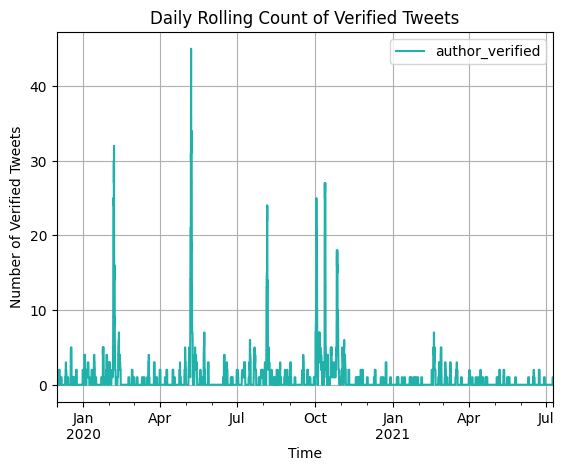

In [27]:
# Rolling on  Verified Account
rolling_1_day_verified_count = tweet_df.resample('1T')['author_verified'].sum().rolling('1D').sum()

rolling_1_day_verified_count.plot(title='Daily Rolling Count of Verified Tweets', color='lightseagreen')
plt.xlabel('Time')
plt.ylabel('Number of Verified Tweets')
plt.legend()
plt.grid(True)
plt.show()

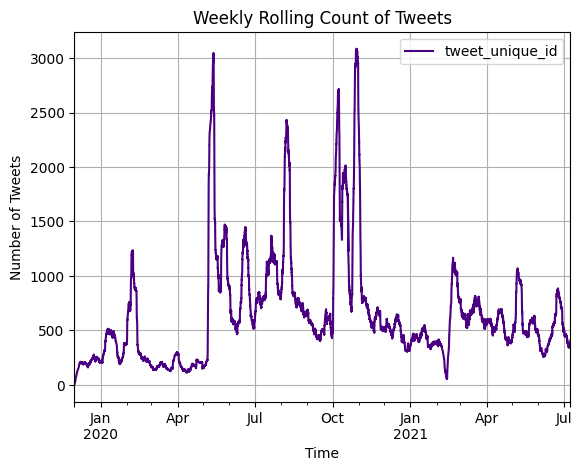

In [28]:
# Rolling  total count of Tweets with a window of 7 days
rolling_7_day_total_tweets = tweet_df.resample('1T')['tweet_unique_id'].count().rolling('7D').sum()

rolling_7_day_total_tweets.plot(title='Weekly Rolling Count of Tweets', color='indigo')
plt.xlabel('Time')
plt.ylabel('Number of Tweets')
plt.legend()
plt.grid(True)
plt.show()

- Merging Twitter Stats into The Price DataFrame

In [29]:
# Setting up new twitter stats DataFrame
twitter_stats = pd.DataFrame({
    'feature__rolling_7_day_total_tweets': rolling_7_day_total_tweets,
    'feature__rolling_1_day_verified_count': rolling_1_day_verified_count
})  

# Index Standarization
twitter_stats.index = pd.to_datetime(twitter_stats.index)  
twitter_stats.index = twitter_stats.index.tz_convert('US/Pacific')  

# Merging Twitter Stats
price_df = price_df.merge(twitter_stats, left_index=True, right_index=True)  

- Looking on Pearson Correlations

In [30]:
price_df.filter(
    regex='feature__'
).corrwith(
    price_df['stock_price_rose']
).sort_values()

feature__rolling_7_day_total_tweets     -0.030404
feature__dayofweek                      -0.002365
feature__expanding_volume_mean          -0.000644
feature__monthly_pct_change_close        0.001672
feature__rolling_1_day_verified_count    0.005921
feature__rolling_volume_mean_60          0.007773
feature__rolling_volume_std_60           0.010038
feature__expanding_close_mean            0.024770
feature__expanding_average_close         0.024801
feature__morning                         0.025106
feature__rolling_close_mean_60           0.030839
feature__lag_30_min_ago_price            0.030878
feature__lag_7_day_ago_price             0.031859
feature__macd                            0.037216
feature__overnight_change_close          0.045098
feature__rolling_close_std_60            0.051801
dtype: float64

### Running Pipeline Again

Add Domain Features
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remov

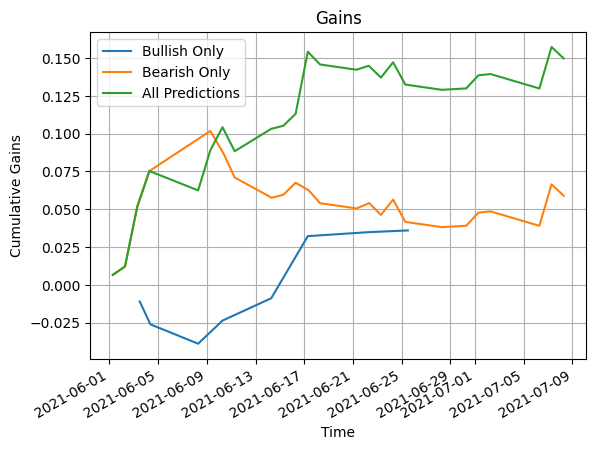

In [31]:
train_df, test_df, train_X, train_y, test_X, test_y = split_data(price_df)

print("Add Domain Features\n==========================")
best_model, test_preds, test_probas = advanced_grid_search(
    train_X, train_y,
    test_X, test_y,
    ml_pipeline, params, 
    cv=tscv, include_probas=True  # C
)

plot_gains(test_df.copy(), test_y, test_preds)

In [32]:
price_df.to_csv('fifteen_percent_gains_features.csv', index=False)

## Feature Selection

### Features Selection using ML

- Select from Model Features Libraries

In [33]:
# Libraries
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

In [34]:
# Features Relevancy
rf = RandomForestClassifier(n_estimators=20, max_depth=None, random_state=0)  
lr = LogisticRegression(random_state=0)

# Setting Pipeline
ml_pipeline = Pipeline([  
    ('scale', StandardScaler()),
    ('select_from_model', SelectFromModel(estimator=rf)),
    ('classifier', clf)
])

# Updating Parameters
params.update({
    'select_from_model__threshold': [
        '0.5 * mean', 'mean', '0.5 * median', 'median'
    ],
    'select_from_model__estimator':  [rf, lr]
})

print("Feature Selection (SFM) \n==========================")
best_model, test_preds, test_probas = advanced_grid_search(
    train_X, train_y,
    test_X, test_y,
    ml_pipeline, params, 
    cv=tscv, include_probas=True  # C
)

Feature Selection (SFM) 
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or 

% of time with profit: 0.000
Total Gains for bullish is -0.038
% of time with profit: 1.000
Total Gains for bearish is 0.017
% of time with profit: 0.923
Total Gains for all predictions is 0.004


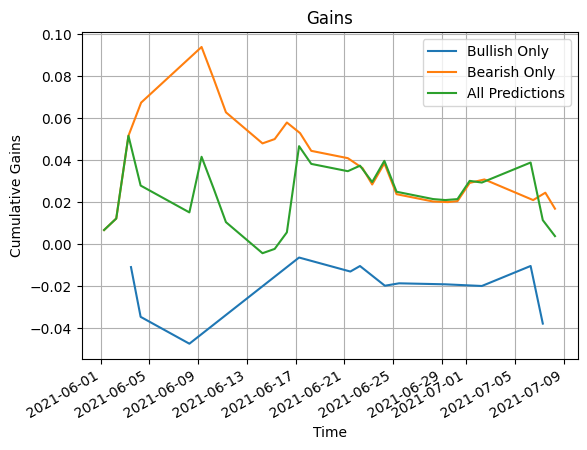

In [35]:
del params['select_from_model__threshold']
del params['select_from_model__estimator']

plot_gains(test_df.copy(), test_y, test_preds)

### Using Recursive Feature Elimination

- Usinf RFE to Restrict Features

In [36]:
from sklearn.feature_selection import RFE

In [37]:
from sklearn.feature_selection import RFE

ml_pipeline = Pipeline([  
    ('scale', StandardScaler()),
    ('rfe', RFE(estimator=rf)),  # A
    ('classifier', clf)
])

params.update({
    'rfe__n_features_to_select': [0.6, 0.7, 0.8, 0.9],
    'rfe__estimator':  [rf, lr]
})

print("Feature Selection (RFE) \n==========================")
best_model, test_preds, test_probas = advanced_grid_search(
    train_X, train_y,
    test_X, test_y,
    ml_pipeline, params, 
    cv=tscv, include_probas=True  # C
)
del params['rfe__n_features_to_select']
del params['rfe__estimator']

Feature Selection (RFE) 
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or 

% of time with profit: 0.000
Total Gains for bullish is -0.063
% of time with profit: 0.381
Total Gains for bearish is -0.027
% of time with profit: 0.077
Total Gains for all predictions is -0.100


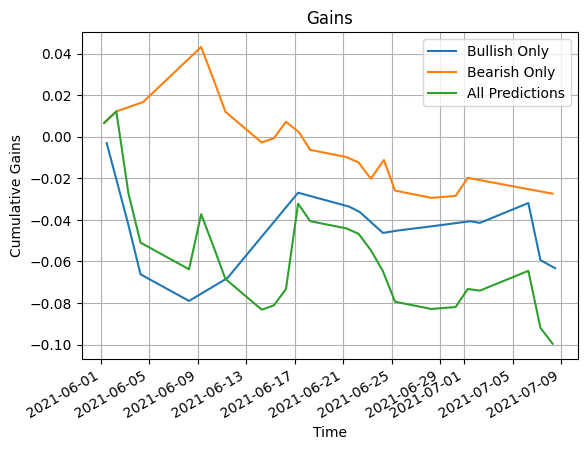

In [38]:
plot_gains(test_df.copy(), test_y, test_preds)

## Feature Extraction

### Polynomial Feature Extraction

In [39]:
from sklearn.preprocessing import PolynomialFeatures

- Example: Polynomial Feature Extraction

In [40]:
p = PolynomialFeatures(3)
small_poly_features = p.fit_transform(
    price_df[['feature__rolling_close_mean_60',
    'feature__rolling_7_day_total_tweets', 
    'feature__morning']])

pd.DataFrame(small_poly_features, columns=p.get_feature_names())

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,1,x0,x1,x2,x0^2,x0 x1,x0 x2,x1^2,x1 x2,x2^2,x0^3,x0^2 x1,x0^2 x2,x0 x1^2,x0 x1 x2,x0 x2^2,x1^3,x1^2 x2,x1 x2^2,x2^3
0,1.0,108.297719,213.0,1.0,11728.396017,23067.414223,108.297719,45369.0,213.0,1.0,1.270159e+06,2.498148e+06,11728.396017,4.913359e+06,23067.414223,108.297719,9663597.0,45369.0,213.0,1.0
1,1.0,108.330916,213.0,1.0,11735.587280,23074.485028,108.330916,45369.0,213.0,1.0,1.271327e+06,2.499680e+06,11735.587280,4.914865e+06,23074.485028,108.330916,9663597.0,45369.0,213.0,1.0
2,1.0,108.358464,213.0,1.0,11741.556642,23080.352755,108.358464,45369.0,213.0,1.0,1.272297e+06,2.500952e+06,11741.556642,4.916115e+06,23080.352755,108.358464,9663597.0,45369.0,213.0,1.0
3,1.0,108.384685,213.0,1.0,11747.240006,23085.937968,108.384685,45369.0,213.0,1.0,1.273221e+06,2.502162e+06,11747.240006,4.917305e+06,23085.937968,108.384685,9663597.0,45369.0,213.0,1.0
4,1.0,108.405694,213.0,1.0,11751.794554,23090.412883,108.405694,45369.0,213.0,1.0,1.273961e+06,2.503132e+06,11751.794554,4.918258e+06,23090.412883,108.405694,9663597.0,45369.0,213.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113257,1.0,384.732251,361.0,0.0,148018.905101,138888.342677,0.000000,130321.0,0.0,0.0,5.694765e+07,5.343482e+07,0.000000,5.013869e+07,0.000000,0.000000,47045881.0,0.0,0.0,0.0
113258,1.0,384.714454,361.0,0.0,148005.211319,138881.917989,0.000000,130321.0,0.0,0.0,5.693974e+07,5.342988e+07,0.000000,5.013637e+07,0.000000,0.000000,47045881.0,0.0,0.0,0.0
113259,1.0,384.690810,361.0,0.0,147987.019194,138873.382361,0.000000,130321.0,0.0,0.0,5.692925e+07,5.342331e+07,0.000000,5.013329e+07,0.000000,0.000000,47045881.0,0.0,0.0,0.0
113260,1.0,384.676488,361.0,0.0,147976.000273,138868.212099,0.000000,130321.0,0.0,0.0,5.692289e+07,5.341934e+07,0.000000,5.013142e+07,0.000000,0.000000,47045881.0,0.0,0.0,0.0


- Polynomial Feature + Select From Model

In [41]:
# Pipeline with Polynomial Features & Adding  SelectFromModel
ml_pipeline = Pipeline([  
    ('poly', PolynomialFeatures(1, include_bias=False)),
    ('scale', StandardScaler()),
    ('select_from_model', SelectFromModel(estimator=rf)),  
    ('classifier', clf)
])

#  Updated Parameters
params.update({
    'select_from_model__threshold': ['0.5 * mean', 'mean', '0.5 * median', 'median'],
    'select_from_model__estimator':  [rf, lr],
    'poly__degree': [2],
})

print("Polynomial Features \n==========================")
best_model, test_preds, test_probas = advanced_grid_search(
    train_X, train_y,
    test_X, test_y,
    ml_pipeline, params, 
    cv=tscv, include_probas=True  
)

del params['poly__degree']
del params['select_from_model__threshold']
del params['select_from_model__estimator']


Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stabl

% of time with profit: 0.737
Total Gains for bullish is 0.028
% of time with profit: 1.000
Total Gains for bearish is 0.095
% of time with profit: 1.000
Total Gains for all predictions is 0.158


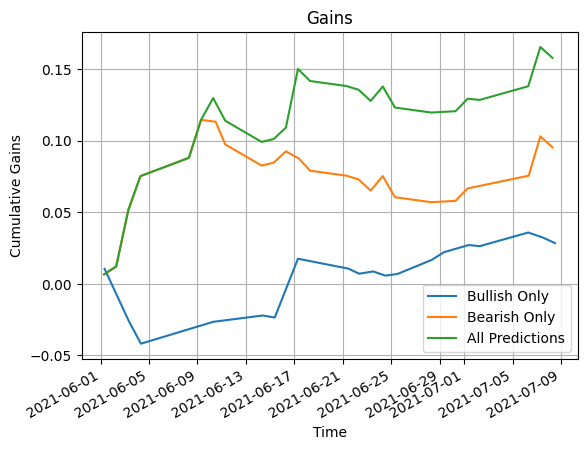

In [42]:
plot_gains(test_df.copy(), test_y, test_preds)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=dbf27b46-0d5e-4210-a4b2-853aee5c37f6' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>